# Magnetic Bottle (Numpy): Introduction

### By Markus Borud Pettersen and Kjetil Gulli

In this notebook, we will use numpy and matplotlib to simulate the motion of a charged particle moving in a magnetic bottle. A magnetic bottle consists of two circular current-carrying loops, oriented a shared z-axis, with equal current in both. That way, a slightly uniform magnetic field will exist between the two. This field is often approximated using a set of two magnetic dipoles
We will not, however, model the bottle using dipoles, but rather model the magnetic field at the very center of the device as a series of equiscalar surfaces, in which the magnetic field only points in the $z$-direction.

Using that model, we wish to investigate if a charged particle can be trapped in a magnetic bottle, and if so, how.

In [71]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numba import jit #This speeds up the simulation
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from numpy.linalg import norm

In [72]:
# Parameters for plot attributes
plt.rc("xtick", labelsize="large")
plt.rc("ytick", labelsize="large")
plt.rc("axes", labelsize="xx-large")
plt.rc("axes", titlesize="xx-large")
plt.rc("figure", figsize=(8,8))


In [73]:
#Now, we define some key constants, like the mass of a proton, the charge of a proton, and the magnetic constant mu_naught

# define key constants
m_p = 1.67E-27       # mass of proton: kg
qe = 1.602E-19        # charge of proton: C
mu0 = np.pi * 4.0E-7 #mu_naught

To create the magnetic field, we will consider two current carrying loops, both of radius $a$, placed a distance $2h$ apart along the $z$-axis. The loops are oriented such that the $z$-axis goes through the center of both loops. We will consider different types of current loops, but will begin by saying they both consist of wound, thin copper wire. The thickness and width of the loops are both considered neglible. 
The contribution to the magnetic field $\vec{B}$ at a position $z = h$, i.e. right between the two loops, from a line element along the loop, may be found to be

$d \vec{B} = \frac{\mu_0 I}{4\pi}\frac{a^2- ab\cos{(\phi - \theta)}}{(a^2 + b^2 + h^2 - 2ab\cos{(\phi - \theta)})^{3/2}} d\phi \hat{k}$

Where $b$ is the radius of the equiscalar surface (a circle at which the magnetic field is constant), $I$ is the current in the loop, $\theta$ is the angle of the position vector of a point on the circle of radius $b$, and $\phi$ is the angle of the position vector of a line element on the current loop. As the expression is somwhat hairy, we will solve it numerically. For reference, the figure below shows how the system is set up.


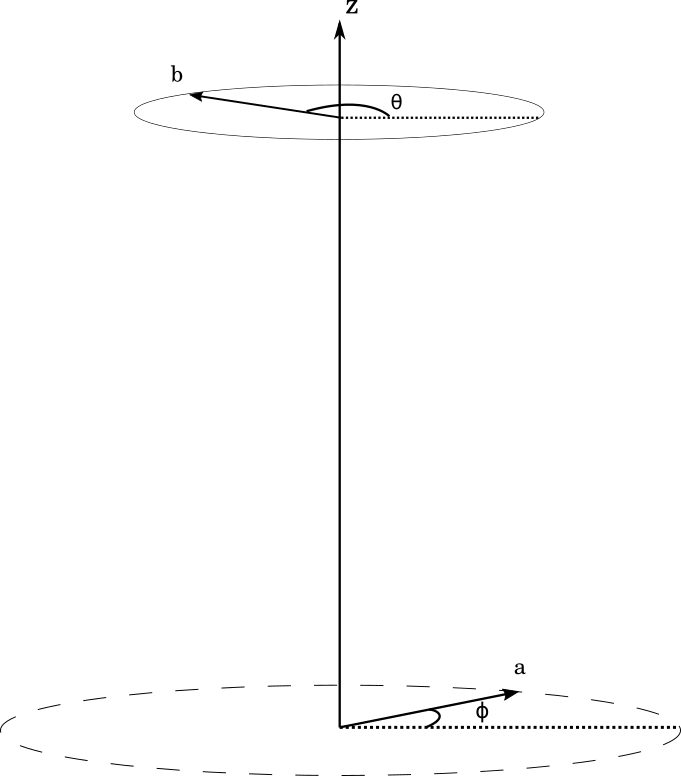

In [74]:
# The jit command ensures fast execution using numba
@jit(nopython = True)
def dBeta(a, b, z, phi, dphi, theta = 0):
    r = np.sqrt(a**2 +b**2 + z**2 - 2*a*b*np.cos(phi - theta))
    dBeta =  mu0/(4*np.pi*r**3)*(a**2 - a*b*np.cos(phi - theta))*dphi
    return 2*np.sum(dBeta)
#magnetic field calculation goes here

We may now find the magnetic field at $z = h$, as a function of distance from the $z$-axis:


Text(0.5, 1.0, 'Magnetic Field Strength')

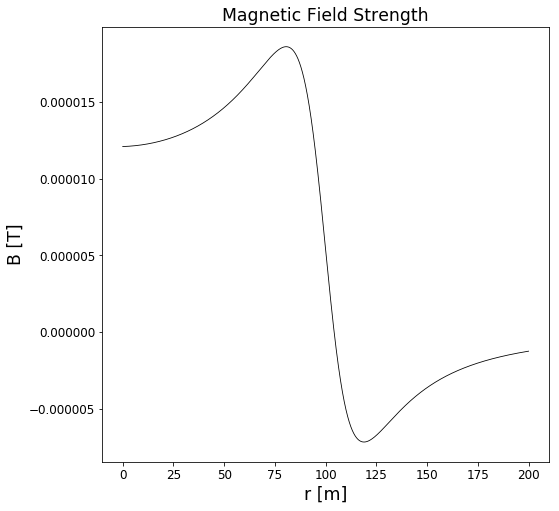

In [75]:

a = 100# Loop radius
z = 20 # Distance between loops
N = 100
I_0 = 10 # First we attempt a strong, constant current
I = N*I_0
steps = 100000
b_lin = np.linspace(0, 200, steps) # Distances from z-axis at midpoint
B = np.zeros(steps)

phi = np.linspace(0, 2*np.pi) # Loop angle
dphi = phi[1] - phi[0] 

for b, i in zip(b_lin, range(len(b_lin))):
    B[i] = I*dBeta(a, b, z, phi, dphi) # Magnetic field

plt.plot(b_lin, B, '-k', linewidth = 0.8)
plt.xlabel('r [m]')
plt.ylabel('B [T]')
plt.title('Magnetic Field Strength')

To investigate what happens when a proton moves into this magnetic bottle, we find the forces acting on it, due to the magnetic field. If the particle is moving with a velocity $v$, it will experience a force from the magnetic field given by the Lorentz force

$\vec{F} = q\vec{v}\times \vec{B}$

From which we may find the velocity and position, given appropriate initial conditions. We will use a simple Euler-Chromer integration scheme for this purpose.


In [76]:
c = 299792458
m_p = 1.67E-27        # mass of proton: kg
qe = 1.602E-19        # charge of proton: C
mu0 = np.pi * 4.0E-7  # mu_naught
system = '100'
if system == 'boring':
    a = 100
    z = a/5
    dt = 6e-6
    end_times = 0.52
    v0 = 100000
    pos0 = np.array([a*0.5, 0, z/2])
    vel0 = np.array([0, v0, 0])
    escape_radius = a*1.2
    I_boring = 10
    N_boring = 100
elif system == '100':
    a = 100
    z = a/5
    dt = 6e-7
    end_times = 0.05
    v0 = 100000
    pos0 = np.array([a*0.5, 0, z/2])
    vel0 = np.array([0, v0, 0])
    escape_radius = a*1.2

In [77]:
theta = 0
steps2 = 100
ending = -1
phi = np.linspace(0,2*np.pi,steps2)
dphi = phi[1]-phi[0]
time = np.arange(0,end_times,dt)
Beta = np.zeros(time.shape)
I = np.zeros(time.shape)
pos = np.zeros([len(time), 3])
vel = np.zeros(pos.shape)
acc = np.zeros(pos.shape)
r = np.zeros(time.shape)
v = np.zeros(time.shape)
steppi = 10
moddus = int(len(time)/steppi)
pos[0] = pos0
r[0] = norm(pos[0,:-1])
vel[0] = vel0
Beta[0] = np.sum(dBeta(a, r[0], z, phi, dphi, theta))
acc[0] = np.cross(qe*vel[0]*I[0]/(m_p) , np.array([0,0,Beta[0]]))
r_desire = r[0]

In [78]:
for k in range(len(time)-1):
    r[k] = norm(pos[k,:-1])
    if r[k] > escape_radius:
        print('particle escaped at t = %.3e, with a speed of %.3e' %(time[k-1], v[k-1]))
        ending = k
        break
    v[k] = norm(vel[k:-1])
    Beta[k] = dBeta(a, r[k], z, phi, dphi, theta)

    r_Delta = (r[k] - r_desire)
    r_factor = 0
    r_factor = (r_Delta + r_desire/50*0)/r_desire
    if system == 'boring':
        I[k] = I_boring * N_boring
    else:
        I[k] = m_p*v[k] / (qe * r[k] * Beta[k]) * (1+r_factor)
    acc[k] = -np.cross(qe*vel[k]*I[k]/(m_p) , np.array([0,0,Beta[k]]))
    vel[k+1] = vel[k] + acc[k]*dt
    pos[k+1] = pos[k] + vel[k+1]*dt
    if k%moddus == 0:
        print('%i of %i' %(k/moddus, steppi))

0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10


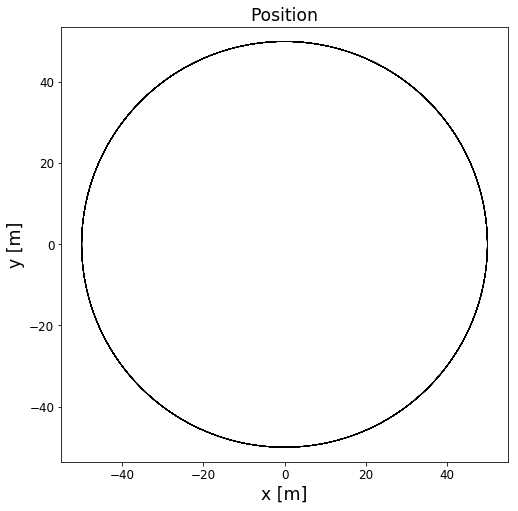

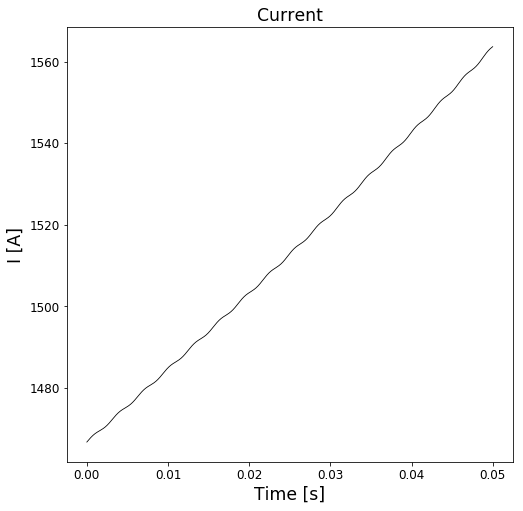

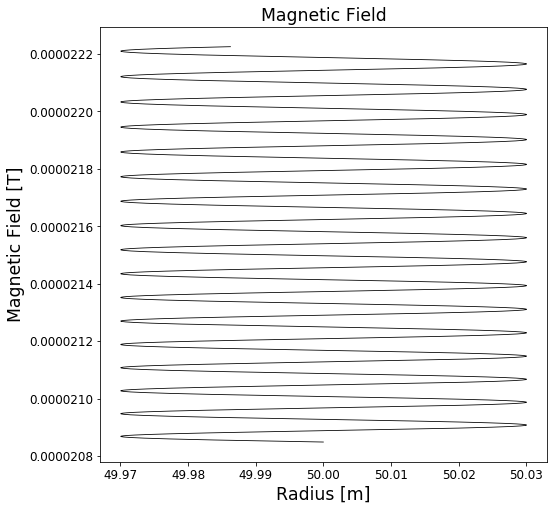

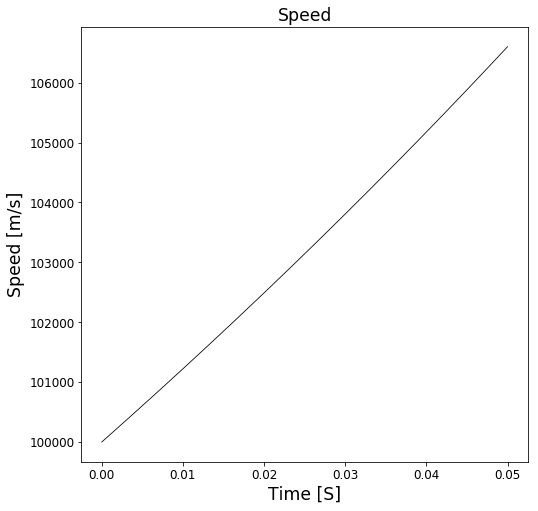

In [79]:
plt.plot(pos[:ending,0], pos[:ending,1], '-k', linewidth = 0.8)
plt.axis('equal')
plt.title('Position')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()
plt.plot(time[:ending], I[:ending], '-k', linewidth = 0.8)
plt.title('Current')
plt.xlabel('Time [s]')
plt.ylabel('I [A]')
plt.show()
plt.plot(r[:ending], Beta[:ending]*I[:ending], '-k', linewidth = 0.8)
plt.title('Magnetic Field')
plt.xlabel('Radius [m]')
plt.ylabel('Magnetic Field [T]')
plt.show()
plt.plot(time[:ending], v[:ending], '-k', linewidth = 0.8)
plt.xlabel('Time [S]')
plt.ylabel('Speed [m/s]')
plt.title('Speed')
plt.show()

As we can see, the particle escapes. And, considering the physical situation, it should actually do so, as it is continually accelerated (and therefore "steals" energy from the magnetic field). To actually trap the proton, we propose a method in which the magnetic field is steadily increased, in order to keep the charged particle, here proton, in a circular "orbit". Now, there is an obvious problem with this method: Since there are no mechanisms for slowing the particle down, we should expect the force required to increase towards infinity, as the particle moves ever faster. 

In [80]:
# Escapes at t = 0.25 s, with speed 1.203e5, v0 = (0,1e5,0)
#r0 = (a*0.5, 0, 0) 

Ignoring that slight problem, we have that the desired radial acceleration for a given speed $v$, if we force the particle into a circular "orbit" of constant radius $r$, is

$a = \frac{v^2}{mr}$
However, our actual acceleration is given by the Lorentz force, and so we have to optimize the velocity vector, in order to circularize the "orbit".

-Electrical resistivity of copper: 1.68*1e-8

http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/rstiv.html


https://www.powerstream.com/Wire_Size.htm

-Let's say 100 windings

-Use the biggest wire gauge from the American Wire Gauge standard: 0000, which corresponds to area of 107 mm$^2$ (diameter 11.684 mm)
gives about 0.16 m$\Omega$/meter

-$R = \frac{\rho l}{A} $

-Total resistance: $R=100\cdot2\pi\cdot100\cdot0.16\cdot10^{-3} \approx 10.05\ \Omega$ since there are 100 windings

-The dissipated power is $P = I^2\cdot R \approx 10 I^2$

In [81]:
# Particle escaped at t = 0.4167, speed of 1.446e8 